In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import pandas as pd
import numpy as np
import os
import sys
import datetime

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
    
load_dotenv()

True

In [2]:
# load datasets
from utils.utils import date_range, preprocess_c

df_train = pd.concat([
    pd.read_csv(f'../datasets/d{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        datetime.date(2019, 11, 1), 
        datetime.date(2020, 2, 1),
        datetime.timedelta(days=1),
    )
])
df_val = pd.concat([
    pd.read_csv(f'../datasets/d{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        datetime.date(2020, 2, 1), 
        datetime.date(2020, 2, 15),
        datetime.timedelta(days=1),
    )
])

X1_train, X2_train, y_train = preprocess_c(df_train)
X1_val, X2_val, y_val = preprocess_c(df_val)

X1_train.shape, X2_train.shape, y_train.shape, X1_val.shape, X2_val.shape, y_val.shape

((1598125, 1, 3),
 (1598125, 7, 3),
 (1598125, 3),
 (263845, 1, 3),
 (263845, 7, 3),
 (263845, 3))

In [3]:
# model structure
from keras.models import Model, clone_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

prev_days = int(os.getenv('PREV_DAYS'))

visible1 = Input(shape=(1, 3))
branch1 = Dense(32, activation='sigmoid')(visible1)
branch1 = Dense(64, activation='sigmoid')(branch1)
branch1 = Flatten()(branch1)

visible2 = Input(shape=(prev_days, 3))
cnn2 = Conv1D(filters=32, kernel_size=3, activation='sigmoid')(visible2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)

merge = concatenate([branch1, cnn2])
dense = Dense(8, activation='relu')(merge)
output = Dense(1, activation=LeakyReLU(alpha=0.01))(dense)
model = Model(inputs=[visible1, visible2], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 3)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7, 3)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 1, 32)        128         ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 5, 32)        320         ['input_2[0][0]']                
                                                                                              

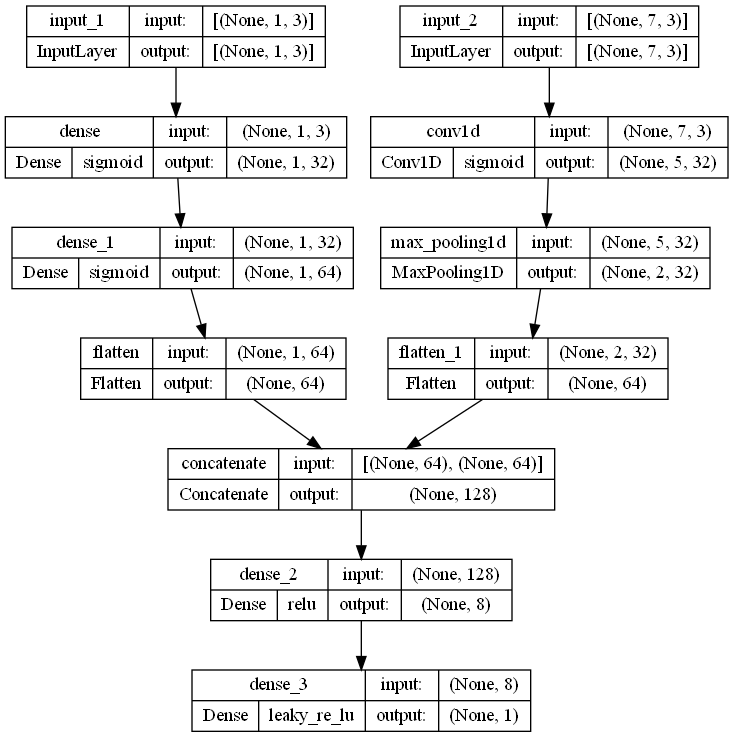

In [4]:
# plot model
from keras.utils import plot_model

plot_model(model,to_file='../.data/model_c.png', show_layer_activations=True, show_shapes=True, show_layer_names=True)

In [5]:
# train view
model_view = clone_model(model)
cp_view = ModelCheckpoint('../model/c-view.keras', save_best_only=True)
model_view.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_view.fit([X1_train, X2_train], y_train[:, 0], validation_data=([X1_val, X2_val], y_val[:, 0]), epochs=10, callbacks=[cp_view])

Epoch 1/10
49942/49942 [==============================] - 85s 2ms/step - loss: 7.2195e-06 - root_mean_squared_error: 0.0027 - val_loss: 1.2883e-05 - val_root_mean_squared_error: 0.0036
Epoch 2/10
49942/49942 [==============================] - 78s 2ms/step - loss: 5.1335e-06 - root_mean_squared_error: 0.0023 - val_loss: 9.1605e-06 - val_root_mean_squared_error: 0.0030
Epoch 3/10
49942/49942 [==============================] - 81s 2ms/step - loss: 4.6447e-06 - root_mean_squared_error: 0.0022 - val_loss: 1.0041e-05 - val_root_mean_squared_error: 0.0032
Epoch 4/10
49942/49942 [==============================] - 80s 2ms/step - loss: 4.1739e-06 - root_mean_squared_error: 0.0020 - val_loss: 9.7788e-06 - val_root_mean_squared_error: 0.0031
Epoch 5/10
49942/49942 [==============================] - 78s 2ms/step - loss: 3.6676e-06 - root_mean_squared_error: 0.0019 - val_loss: 8.6624e-06 - val_root_mean_squared_error: 0.0029
Epoch 6/10
49942/49942 [==============================] - 81s 2ms/step - lo

In [6]:
# train cart
model_cart = clone_model(model)
cp_cart = ModelCheckpoint('../model/c-cart.keras', save_best_only=True)
model_cart.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_cart.fit([X1_train, X2_train], y_train[:, 1], validation_data=([X1_val, X2_val], y_val[:, 1]), epochs=10, callbacks=[cp_cart])

Epoch 1/10
49942/49942 [==============================] - 86s 2ms/step - loss: 3.2294e-04 - root_mean_squared_error: 0.0180 - val_loss: 1.1761e-05 - val_root_mean_squared_error: 0.0034
Epoch 2/10
49942/49942 [==============================] - 81s 2ms/step - loss: 1.0707e-05 - root_mean_squared_error: 0.0033 - val_loss: 1.5830e-05 - val_root_mean_squared_error: 0.0040
Epoch 3/10
49942/49942 [==============================] - 79s 2ms/step - loss: 1.0174e-05 - root_mean_squared_error: 0.0032 - val_loss: 1.0931e-05 - val_root_mean_squared_error: 0.0033
Epoch 4/10
49942/49942 [==============================] - 81s 2ms/step - loss: 9.8402e-06 - root_mean_squared_error: 0.0031 - val_loss: 1.1341e-05 - val_root_mean_squared_error: 0.0034
Epoch 5/10
49942/49942 [==============================] - 80s 2ms/step - loss: 9.6615e-06 - root_mean_squared_error: 0.0031 - val_loss: 1.1245e-05 - val_root_mean_squared_error: 0.0034
Epoch 6/10
49942/49942 [==============================] - 81s 2ms/step - lo

In [7]:
# train purchase
model_purchase = clone_model(model)
cp_purchase = ModelCheckpoint('../model/c-purchase.keras', save_best_only=True)
model_purchase.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_purchase.fit([X1_train, X2_train], y_train[:, 2], validation_data=([X1_val, X2_val], y_val[:, 2]), epochs=10, callbacks=[cp_purchase])

Epoch 1/10
49942/49942 [==============================] - 86s 2ms/step - loss: 5.0505e-05 - root_mean_squared_error: 0.0071 - val_loss: 3.4385e-05 - val_root_mean_squared_error: 0.0059
Epoch 2/10
49942/49942 [==============================] - 84s 2ms/step - loss: 3.9329e-05 - root_mean_squared_error: 0.0063 - val_loss: 3.1607e-05 - val_root_mean_squared_error: 0.0056
Epoch 3/10
49942/49942 [==============================] - 84s 2ms/step - loss: 3.7688e-05 - root_mean_squared_error: 0.0061 - val_loss: 2.9310e-05 - val_root_mean_squared_error: 0.0054
Epoch 4/10
49942/49942 [==============================] - 86s 2ms/step - loss: 3.6684e-05 - root_mean_squared_error: 0.0061 - val_loss: 2.4720e-05 - val_root_mean_squared_error: 0.0050
Epoch 5/10
49942/49942 [==============================] - 92s 2ms/step - loss: 3.6059e-05 - root_mean_squared_error: 0.0060 - val_loss: 2.4150e-05 - val_root_mean_squared_error: 0.0049
Epoch 6/10
49942/49942 [==============================] - 82s 2ms/step - lo